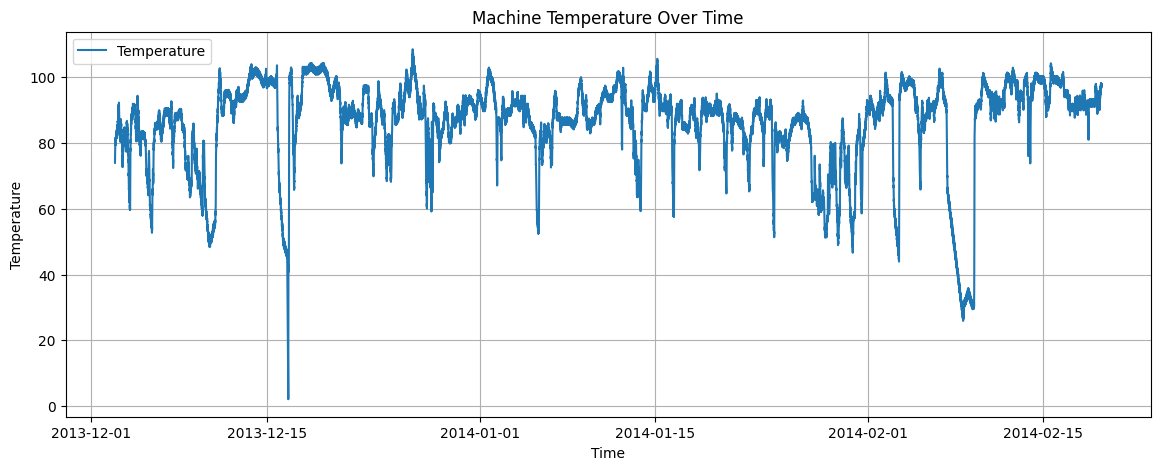

✅ Train shape: (15886, 2)
✅ Test shape: (6809, 2)


C:\Users\user\AppData\Local\Temp\ipykernel_41972\1387560227.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'anomaly'] = iso_forest.predict(train[['temp_scaled']])
C:\Users\user\AppData\Local\Temp\ipykernel_41972\1387560227.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'anomaly'] = iso_forest.predict(test[['temp_scaled']])
C:\Users\user\AppData\Local\Temp\ipykernel_41972\1387560227.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

🚨 Train anomalies: 158
🚨 Test anomalies: 515


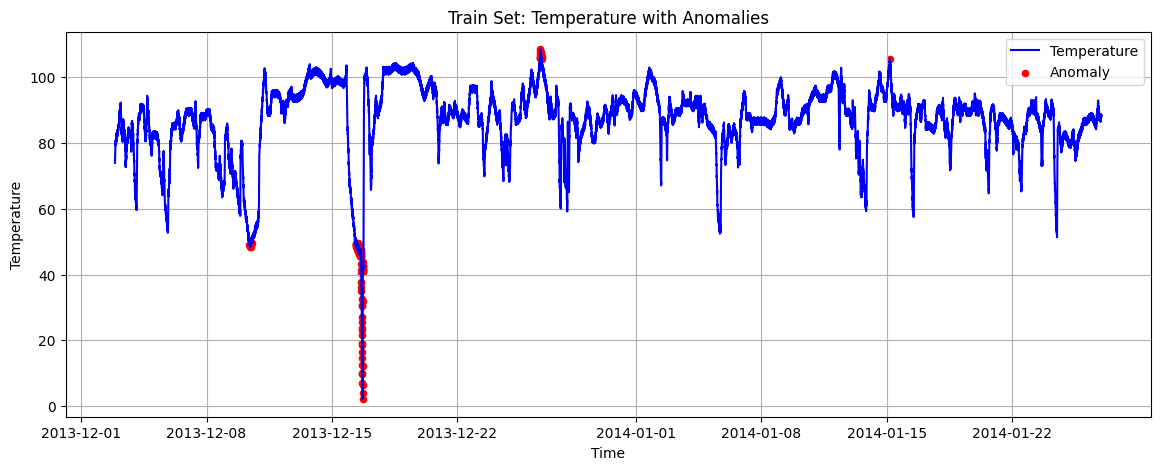

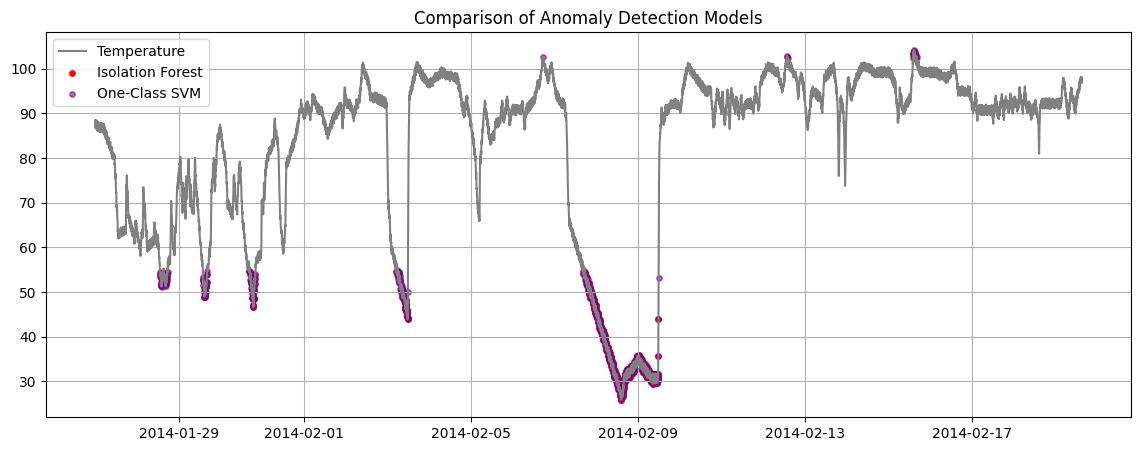

Isolation Forest Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       360
           1       0.30      0.02      0.04      6449

    accuracy                           0.02      6809
   macro avg       0.15      0.01      0.02      6809
weighted avg       0.29      0.02      0.04      6809

One-Class SVM Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       360
           1       0.51      0.06      0.11      6449

    accuracy                           0.06      6809
   macro avg       0.26      0.03      0.05      6809
weighted avg       0.49      0.06      0.10      6809

Anomaly Rate: 7.56%


C:\Users\user\AppData\Local\Temp\ipykernel_41972\1387560227.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['true_anomaly'] = test['temp'].apply(lambda x: 1 if x > 38 or x < 20 else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_41972\1387560227.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['if_pred'] = test['anomaly'].apply(lambda x: 1 if x == -1 else 0)
C:\Users\user\AppData\Local\Temp\ipykernel_41972\1387560227.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import OneClassSVM



# ✅ File path to your CSV file
file_path = r"C:\Users\user\Music\real_time_anomaly_detection\data\NAB-master\NAB-master\data\realKnownCause\machine_temperature_system_failure.csv"


# Load and preprocess data
df = pd.read_csv(file_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.rename(columns={'value': 'temp'}, inplace=True)

# Plot temperature over time
plt.figure(figsize=(14,5))
plt.plot(df.index, df['temp'], label='Temperature')
plt.title('Machine Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Normalize
scaler = MinMaxScaler()
df['temp_scaled'] = scaler.fit_transform(df[['temp']])

# Train-test split
train_size = int(len(df) * 0.7)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"✅ Train shape: {train.shape}")
print(f"✅ Test shape: {test.shape}")

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(train[['temp_scaled']])

# Predict anomalies on both train and test sets
train.loc[:, 'anomaly'] = iso_forest.predict(train[['temp_scaled']])
test.loc[:, 'anomaly'] = iso_forest.predict(test[['temp_scaled']])

svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
svm.fit(train[['temp_scaled']])
test['svm_anomaly'] = svm.predict(test[['temp_scaled']])


# -1 = anomaly, 1 = normal
print("🚨 Train anomalies:", np.sum(train['anomaly'] == -1))
print("🚨 Test anomalies:", np.sum(test['anomaly'] == -1))

# Plot train data with anomalies
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['temp'], label='Temperature', color='blue')
plt.scatter(train.index[train['anomaly'] == -1], 
            train['temp'][train['anomaly'] == -1], 
            color='red', label='Anomaly', s=20)
plt.title('Train Set: Temperature with Anomalies')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(test.index, test['temp'], label='Temperature', color='gray')
plt.scatter(test.index[test['anomaly'] == -1], test['temp'][test['anomaly'] == -1], 
            color='red', label='Isolation Forest', s=15)
plt.scatter(test.index[test['svm_anomaly'] == -1], test['temp'][test['svm_anomaly'] == -1], 
            color='purple', label='One-Class SVM', s=15, alpha=0.6)
plt.title("Comparison of Anomaly Detection Models")
plt.legend()
plt.grid(True)
plt.show()

test['true_anomaly'] = test['temp'].apply(lambda x: 1 if x > 38 or x < 20 else 0)

# Isolation Forest
test['if_pred'] = test['anomaly'].apply(lambda x: 1 if x == -1 else 0)
print("Isolation Forest Report:")
print(classification_report(test['true_anomaly'], test['if_pred']))

# One-Class SVM
test['svm_pred'] = test['svm_anomaly'].apply(lambda x: 1 if x == -1 else 0)
print("One-Class SVM Report:")
print(classification_report(test['true_anomaly'], test['svm_pred']))


anomaly_rate = (test['anomaly'] == -1).mean() * 100
print(f"Anomaly Rate: {anomaly_rate:.2f}%")


